In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset

In [2]:
zip_path = tf.keras.utils.get_file(
    fname='jena_climate_2009_2016.csv.zip',
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data =[]
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 300000

In [6]:
tf.random.set_seed(13)

## Part 1: Forcast a univariate time series

First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

In [7]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0fc1aedc10>],
      dtype=object)

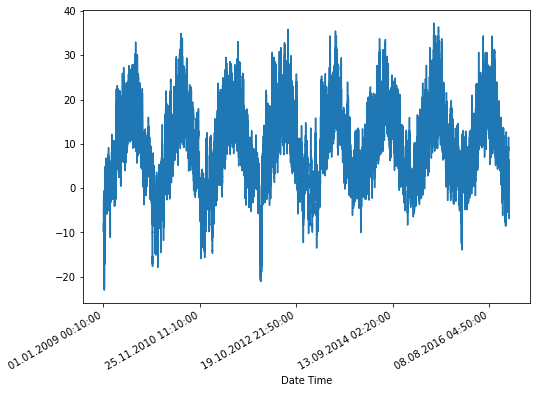

In [8]:
uni_data.plot(subplots=True)

In [9]:
uni_data = uni_data.values

In [10]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [11]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [12]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data,
                                           start_index=0, end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data,
                                       start_index=TRAIN_SPLIT, end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

In [13]:
def create_time_steps(length):
    return list(range(-length, 0))

In [61]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        # future & predicted data
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        # history data
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

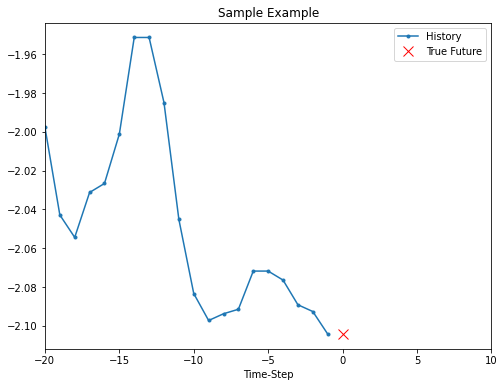

In [15]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline

In [16]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

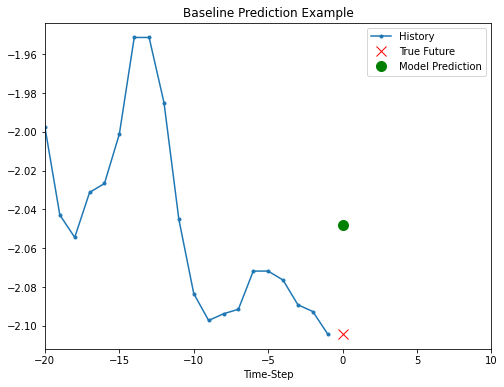

In [17]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], delta=0, title='Baseline Prediction Example')

### Recurrent neural network

In [18]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = (tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
                    .cache()
                    .shuffle(BUFFER_SIZE)
                    .batch(BATCH_SIZE)
                    .repeat())
val_univariate = (tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
                  .batch(BATCH_SIZE)
                  .repeat())

In [19]:
simple_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]), # input_shape excludes batch dimension
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='Adam', loss=tf.keras.losses.mean_absolute_error)

In [20]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate,
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1118 - val_loss: 0.0360
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0490 - val_loss: 0.0289
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0444 - val_loss: 0.0257
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0287 - val_loss: 0.0206
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0263 - val_loss: 0.0200
Epoch 9/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0228 - val_loss: 0.0173

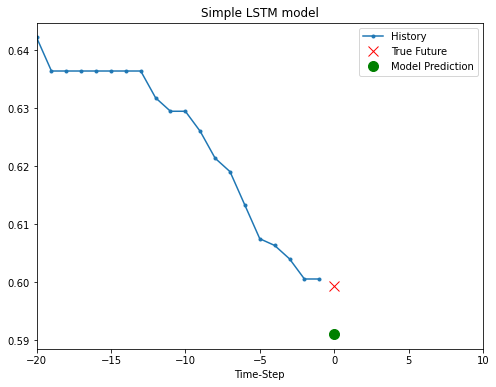

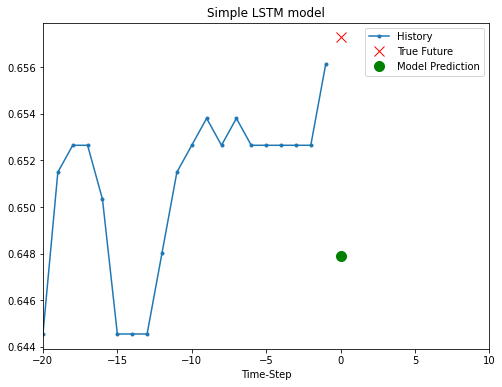

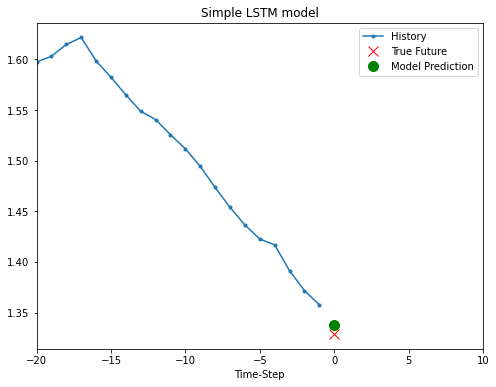

In [21]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

## Part 2: Forcast a multivariate time series

In [22]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [23]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f5c01d2d0>,
      dtype=object)

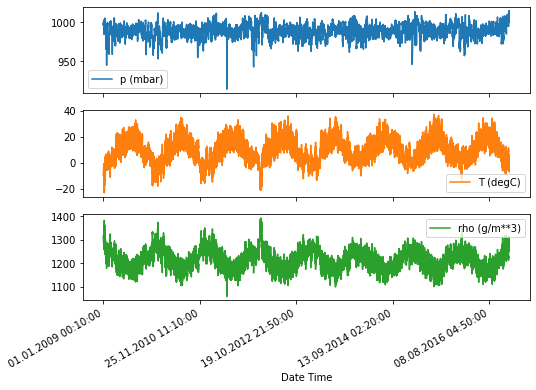

In [24]:
features.plot(subplots=True)

In [25]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [26]:
dataset = (dataset-data_mean)/data_std

In [30]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i: i+target_size])
    
    return np.array(data), np.array(labels)

###  Single step model

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, `120 observation represent history of the last five days`. For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. `In order to create a label for this, the temperature after 72(12*6) observations is used`.

In [31]:
past_history = 720 # 5 * 6 * 24
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset=dataset,
                                                   target=dataset[:, 1],
                                                   start_index=0,
                                                   end_index=TRAIN_SPLIT,
                                                   history_size=past_history,
                                                   target_size=future_target,
                                                   step=STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset=dataset,
                                               target=dataset[:, 1],
                                               start_index=TRAIN_SPLIT,
                                               end_index=None,
                                               history_size=past_history,
                                               target_size=future_target,
                                               step=STEP,
                                               single_step=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

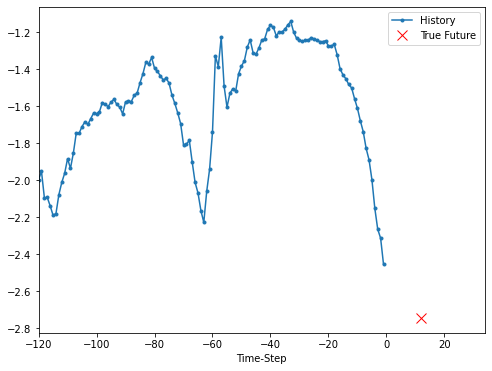

In [77]:
show_plot([x_train_single[0][:, 1], y_train_single[0]], future_target//STEP, '')

In [78]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [79]:
single_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]),
    tf.keras.layers.Dense(1)
])

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [80]:
single_step_history = single_step_model.fit(train_data_single,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 11ms/step - loss: 0.3090 - val_loss: 0.2646
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2624 - val_loss: 0.2435
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2616 - val_loss: 0.2472
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2567 - val_loss: 0.2442
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2263 - val_loss: 0.2346
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2419 - val_loss: 0.2643
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2411 - val_loss: 0.2573
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2409 - val_loss: 0.2375
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2450 - val_loss: 0.2481
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2388 - val_loss: 0

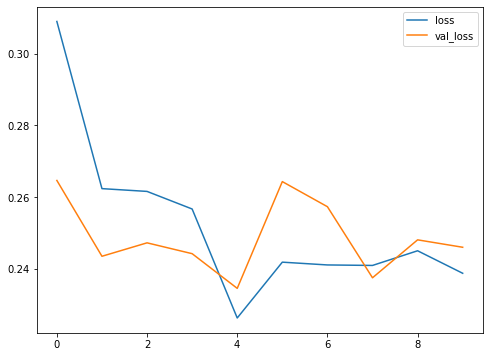

In [86]:
pd.DataFrame(single_step_history.history).plot(subplots=False)

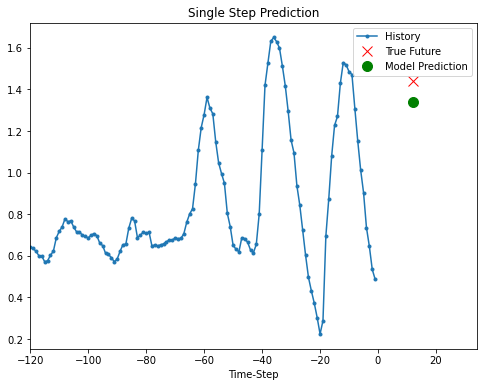

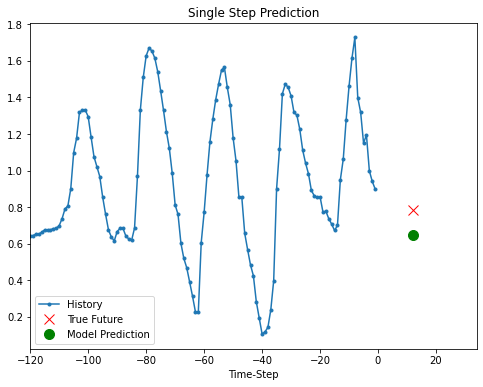

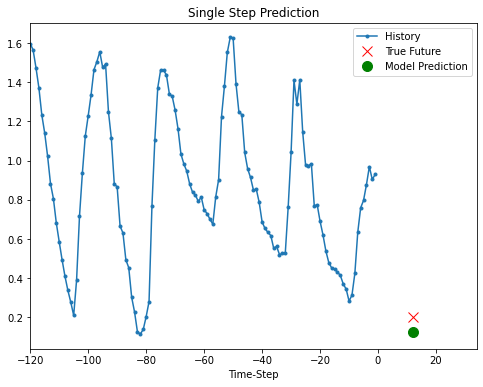

In [87]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(), single_step_model.predict(x)[0]],
                     delta=future_target//STEP,
                     title='Single Step Prediction')
    plot.show()

### Multi-Step model

In [88]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset=dataset,
                                                 target=dataset[:, 1],
                                                 start_index=0,
                                                 end_index=TRAIN_SPLIT,
                                                 history_size=past_history,
                                                 target_size=future_target,
                                                 step=STEP,
                                                 single_step=False)
x_val_multi, y_val_multi = multivariate_data(dataset=dataset,
                                             target=dataset[:, 1],
                                             start_index=TRAIN_SPLIT,
                                             end_index=None,
                                             history_size=past_history,
                                             target_size=future_target,
                                             step=STEP,
                                             single_step=False)

In [92]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)
Target temperature to predict : (72,)


In [93]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [99]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    # history
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    # future
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    # prediction
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')

    plt.legend(loc='upper left')
    plt.show()

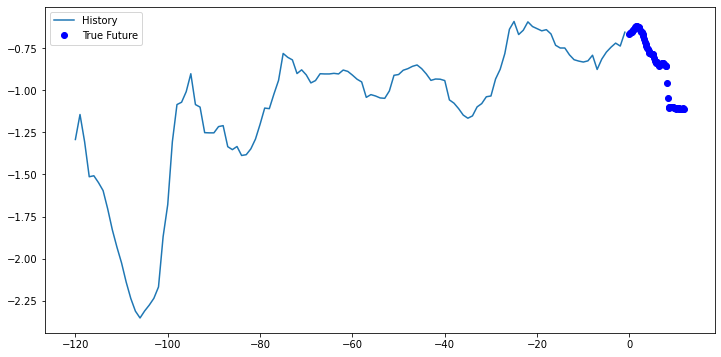

In [100]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [101]:
multi_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dense(72)
])

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [102]:
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 37s 184ms/step - loss: 110.7665 - val_loss: 0.3094
Epoch 2/10
200/200 [==============================] - 38s 188ms/step - loss: 110.7963 - val_loss: 0.2832
Epoch 3/10
200/200 [==============================] - 36s 179ms/step - loss: 0.3775 - val_loss: 0.2745
Epoch 4/10
200/200 [==============================] - 38s 188ms/step - loss: 0.2902 - val_loss: 0.2150
Epoch 5/10
200/200 [==============================] - 35s 175ms/step - loss: 0.2090 - val_loss: 0.1978
Epoch 6/10
200/200 [==============================] - 33s 167ms/step - loss: 0.2120 - val_loss: 0.2187
Epoch 7/10
200/200 [==============================] - 35s 173ms/step - loss: 0.2033 - val_loss: 0.2100
Epoch 8/10
200/200 [==============================] - 36s 180ms/step - loss: 0.1978 - val_loss: 0.2107
Epoch 9/10
200/200 [==============================] - 37s 183ms/step - loss: 0.2018 - val_loss: 0.1953
Epoch 10/10
200/200 [==============================] - 34s 169ms/step

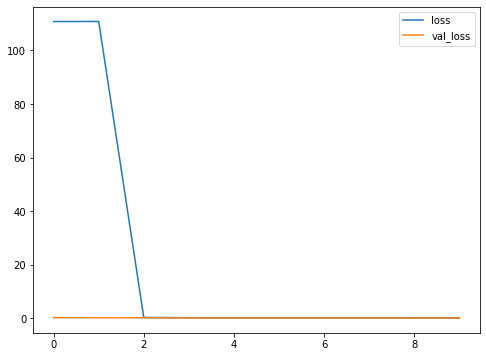

In [103]:
pd.DataFrame(multi_step_history.history).plot(subplots=False)

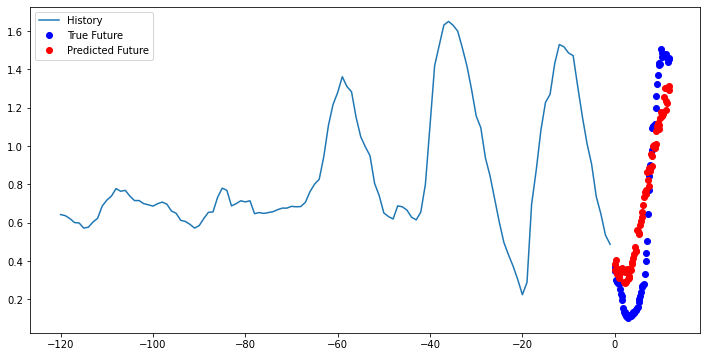

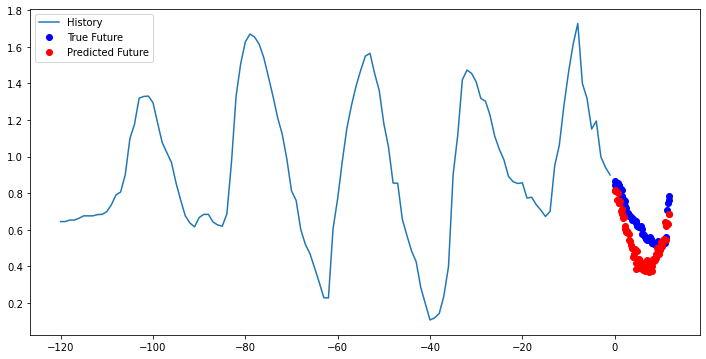

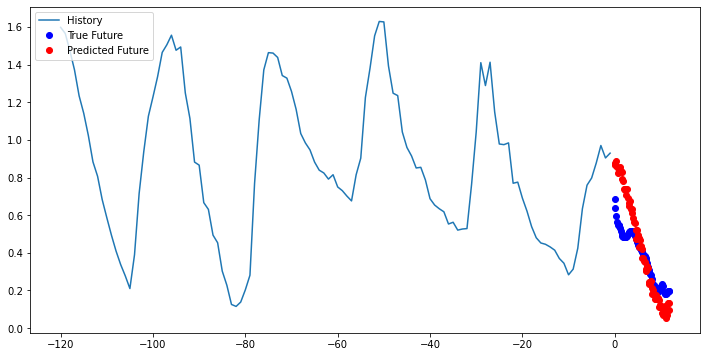

In [104]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])